<a href="https://colab.research.google.com/github/msds18057/msds18058_COVID19_DLSpring2020/blob/master/covid19_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import f1_score

In [3]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder('/content/Assignment 5 Dataset/train', transform=train_transforms)
validation_data = datasets.ImageFolder('/content/Assignment 5 Dataset/validation', transform=train_transforms)
test_data = datasets.ImageFolder('/content/Assignment 5 Dataset/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True,num_workers=5)
testloader = torch.utils.data.DataLoader(test_data, batch_size=200, shuffle=True,num_workers=5)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=200, shuffle=True,num_workers=5)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


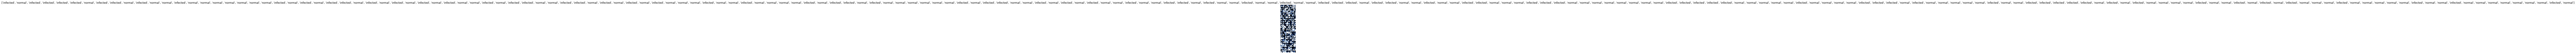

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [5]:
# Load the pretrained model from pytorch
ResNet18 = models.resnet18(pretrained=True)
print(ResNet18)
print('Output Layer of ResNet18 : ', ResNet18.fc.out_features) # 1000 


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [6]:
num_features = ResNet18.fc.in_features
#nn.Sequential(*list(ResNet18.children())[:-1])
features = (list(ResNet18.children())[:-1]) # Remove last layer
print(features)

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [0]:
# Freeze training for all layers
for param in ResNet18.parameters():
    param.require_grad = False

In [0]:
features.clear
features.extend([nn.Linear(num_features, 680)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Linear(680,2)])

In [9]:
ResNet18.classifier = nn.Sequential(*features)
print(ResNet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet18.parameters(), lr=0.001, momentum=0.9)

In [12]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ResNet18.to(device)
ResNet18.train()
EpochlosslistTrain=[]
EpochAccListTrain=[]    
for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    i=0    
    losslistTrain=[]
    AccListTrain=[]    
    for i,data in pbar:
        correct = 0
        total = 0
        # get the inputs
        inputs, labels = data        
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs = ResNet18(inputs)               #----> forward pass        
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc=100 * correct / total
        AccListTrain.append(acc)
        losslistTrain.append(loss.data.item()) 
        # print statistics
        running_loss += loss.item()        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
        i+=1    
    losstrain=sum(losslistTrain)/len(losslistTrain)
    acctrain=sum(AccListTrain)/len(AccListTrain)    
    EpochlosslistTrain.append(losstrain)
    EpochAccListTrain.append(acctrain)
    torch.save(ResNet18.state_dict(), 'res18_FC_Only.pth')

print('Finished Training')


0it [00:00, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 8.911967: : 0it [00:18, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 8.911967: : 1it [00:18, 18.80s/it]
Train Epoch: 0 [200/12000 (2%)]	Loss: 8.542279: : 1it [00:19, 18.80s/it]
Train Epoch: 0 [200/12000 (2%)]	Loss: 8.542279: : 2it [00:19, 13.41s/it]
Train Epoch: 0 [400/12000 (3%)]	Loss: 7.553513: : 2it [00:20, 13.41s/it]
Train Epoch: 0 [400/12000 (3%)]	Loss: 7.553513: : 3it [00:20,  9.66s/it]
Train Epoch: 0 [600/12000 (5%)]	Loss: 6.848579: : 3it [00:21,  9.66s/it]
Train Epoch: 0 [600/12000 (5%)]	Loss: 6.848579: : 4it [00:21,  7.01s/it]
Train Epoch: 0 [800/12000 (7%)]	Loss: 5.732825: : 4it [00:22,  7.01s/it]
Train Epoch: 0 [800/12000 (7%)]	Loss: 5.732825: : 5it [00:22,  5.18s/it]
Train Epoch: 0 [1000/12000 (8%)]	Loss: 4.529079: : 5it [00:38,  5.18s/it]
Train Epoch: 0 [1000/12000 (8%)]	Loss: 4.529079: : 6it [00:38,  8.51s/it]
Train Epoch: 0 [1200/12000 (10%)]	Loss: 3.648455: : 6it [00:39,  8.51s/it]
Train Epoch: 0 [1200/12000 (10%)]	L

Finished Training


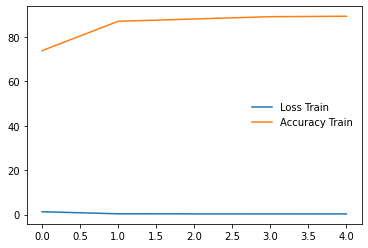

In [18]:
import matplotlib.pyplot as pltt
pltt.plot(EpochlosslistTrain,label='Loss Train')
pltt.plot(EpochAccListTrain,label='Accuracy Train')
pltt.legend(frameon=False)
pltt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


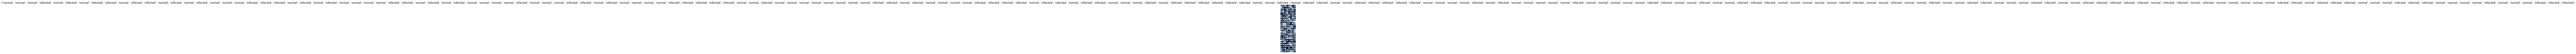

In [19]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [20]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = ResNet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal infected normal normal normal infected infected normal infected infected normal normal normal infected normal normal normal infected infected infected normal infected normal infected normal normal normal normal infected infected normal infected normal infected normal normal normal normal infected normal normal normal infected infected normal infected normal normal normal normal infected infected infected infected infected normal normal infected normal normal normal normal normal normal normal normal infected infected normal infected normal normal normal normal infected infected infected infected normal infected infected normal infected infected normal normal normal infected normal infected infected infected infected infected infected normal normal infected normal infected infected normal normal infected normal infected infected infected normal normal normal normal infected normal infected normal normal normal normal normal infected normal normal normal 

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = ResNet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 95 %


In [23]:
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = ResNet18(images)
        _, predicted = torch.max(outputs.data, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[570.,  45.],
        [ 34., 851.]])
<class 'torch.Tensor'>


In [24]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [25]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
print(features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

In [0]:
features.extend([nn.Linear(num_features, len(class_names))])

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.train()
EpochlosslistTrain=[]
EpochAccListTrain=[]    
for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    i=0    
    losslistTrain=[]
    AccListTrain=[]    
    for i,data in pbar:
        correct = 0
        total = 0
        # get the inputs
        inputs, labels = data        
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass        
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc=100 * correct / total
        AccListTrain.append(acc)
        losslistTrain.append(loss.data.item()) 
        # print statistics
        running_loss += loss.item()        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
        i+=1    
    losstrain=sum(losslistTrain)/len(losslistTrain)
    acctrain=sum(AccListTrain)/len(AccListTrain)    
    EpochlosslistTrain.append(losstrain)
    EpochAccListTrain.append(acctrain)
    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')

print('Finished Training')

In [0]:
import matplotlib.pyplot as pltt
pltt.plot(EpochlosslistTrain,label='Loss Train')
pltt.plot(EpochAccListTrain,label='Accuracy Train')
pltt.legend(frameon=False)
pltt.show()

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = ResNet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

In [0]:
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = ResNet18(images)
        _, predicted = torch.max(outputs.data, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)